# Scrape Twitter, Clean Tweets, Analyze results
Calen McNickles

1. Scrape most recent designated number of tweets and export them to sqlite db - recommended for larger scrapes. You can also use the scraped tweet df directly with the rest of the notebook, otherwise export the df directly to a csv - recommended for smaller scrapes.
2. Clean all of the tweets text and get the df down to individual words and their count. 
3. Scrape specified number of coin names and tickers from coingecko.com.
4. Count only occruences of coin names and tickers within the scraped tweets.

# 1. Scrape by username and exports to sql db
Credit to Martin Beck for the snscrape walklthrough - https://betterprogramming.pub/how-to-scrape-tweets-with-snscrape-90124ed006af

In [1]:
# imports
import snscrape.modules.twitter as sntwitter
import pandas as pd
import sqlite3
import sqlalchemy

In [2]:
# database used to export tweets
engine = sqlalchemy.create_engine('sqlite:///twitter_crypto.db')

In [3]:
# imports list of twitter crypto influencer user names
twitter_users = pd.read_csv('csv/twitter_crypto_influencers.csv')

In [4]:
twitter_users.head()

,names
0,Justin_Bons
1,CyberCapital
2,gavofyork
3,haydenzadams
4,MessariCrypto


In [5]:
# loops through lists of tweeter users -> creates df with scraped tweets -> exports to SQL. Ideal for larger scrapes
def twitter_scrape_usernames_to_db(max_tweets, name_df):
    for name in user_list:
        tweets_list1 = []
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{name}').get_items()):
            if i > maxTweets:
                break
            tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
        tweets_df1 = pd.DataFrame(tweets_list1, columns=['datetime', 'tweet_id', 'text', 'username']) # creates df of tweets
        tweets_df1.to_sql('tweets', engine, if_exists='append', index=False) # exports to sqlite

In [6]:
# loops through lists of tweeter users -> creates df with scraped tweets. Ideal for smaller tweet scrapes
def twitter_scrape_usernames(max_tweets, name_df):
    max_tweets = max_tweets  
    user_list = name_df['names'].tolist()    
    tweets_list1 = []
    for name in user_list:
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{name}').get_items()):
            if i > max_tweets:
                break
            tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    tweets_df1 = pd.DataFrame(tweets_list1, columns=['datetime', 'tweet_id', 'text', 'username']) # creates df of tweets
    return tweets_df1

In [7]:
# scrape tweets for each user on the twitter_users df and exports to sqlite db
# twitter_scrape_usernames_to_db(1, twitter_users)

In [8]:
# scrape tweets for each user on the twitter_users df
tweets_df = twitter_scrape_usernames(1000, twitter_users)

In [9]:
tweets_df.head()

,datetime,tweet_id,text,username
0,2022-01-12 04:51:04+00:00,1481126558999977989,@sedonatvcom I will stand by that statement.\n...,Justin_Bons
1,2022-01-11 23:46:31+00:00,1481049916826869760,"@boaserichard For the sake of argument, even i...",Justin_Bons
2,2022-01-11 23:35:50+00:00,1481047229876088834,@boaserichard Good question\n\nI would support...,Justin_Bons
3,2022-01-11 23:26:52+00:00,1481044970761076744,"I am an anti-maximalist, I want there to be ma...",Justin_Bons
4,2022-01-11 23:16:16+00:00,1481042304513286146,@CryptoInf0rm @joemccann Correct!\n\nThe equiv...,Justin_Bons


In [10]:
# export dataframe as csv
# tweets_df.to_csv('user-tweets.csv', sep=',', index=False)

# 2. Clean and count tweet keywords
I found 'Alex The Analysts' video helpful if anyone is struggling with this section. https://www.youtube.com/watch?v=MpIi4HtCiVk&t=114s

In [11]:
# imports
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

In [12]:
# read csv
# df = pd.read_csv('user-tweets.csv')

In [13]:
# remove @usersnames from tweets  
tweets_df['text']=tweets_df['text'].str.replace('(\@\w+.*?)',"")

<ipython-input-13-1c6a5f7f5586>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['text']=tweets_df['text'].str.replace('(\@\w+.*?)',"")


In [14]:
tweets_df.head()

,datetime,tweet_id,text,username
0,2022-01-12 04:51:04+00:00,1481126558999977989,I will stand by that statement.\n\nI will lis...,Justin_Bons
1,2022-01-11 23:46:31+00:00,1481049916826869760,"For the sake of argument, even if BSV is the ...",Justin_Bons
2,2022-01-11 23:35:50+00:00,1481047229876088834,Good question\n\nI would support it &amp; you...,Justin_Bons
3,2022-01-11 23:26:52+00:00,1481044970761076744,"I am an anti-maximalist, I want there to be ma...",Justin_Bons
4,2022-01-11 23:16:16+00:00,1481042304513286146,Correct!\n\nThe equivalant of a mempool is c...,Justin_Bons


In [15]:
# splits all the sentences up into individual words
list_of_sentences = [word for word in tweets_df.text]

lines = []
for line in list_of_sentences:    
    words = line.split()
    for w in words: 
       lines.append(w.lower())

In [16]:
# using regular expression to remove all punctuation
lines = [re.sub(r'[^A-Za-z0-9]+','',x) for x in lines]
lines2 = []

for w in lines:
    if w != '':
        lines2.append(w)

In [17]:
# create stopwords list
stop_words = set(stopwords.words("english"))

In [18]:
# add stopwords to list, this step isnt necessary as we will be counting key words later in the notebook. Still useful if you want to make changes. 
new_stopwords = ['i','want','The','like','people','one','dont','get','this','know','good']

for i in new_stopwords:
    stop_words.add(i)

In [19]:
# filter out stopwords
filtered_sentence = [w for w in lines2 if not w in stop_words]

In [21]:
df = pd.DataFrame(filtered_sentence)
top_words = df[0].value_counts().reset_index()
top_words.columns = ['word','count']

In [22]:
top_words.head()

,word,count
0,bitcoin,7166
1,crypto,3566
2,amp,3273
3,new,2891
4,time,2461


In [23]:
# exports to csv
# df.to_csv('top_word_6_2020_6_2021.csv')

# 3. Scrape coin names and tickers from coingecko

In [24]:
# imports
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [25]:
# scrapes coin page, 100 per page, name & ticker from coin gecko and create a df
def scape_coin_names(pages):
    all_coins = []
    for i in range(1,pages):
        # request site
        cypto_price = requests.get(f'https://www.coingecko.com/en?page={i}')
        soup = BeautifulSoup(cypto_price.content, 'html.parser')

        # find all coin names
        names = soup.find_all('a',{'class': 'tw-hidden lg:tw-flex font-bold tw-items-center tw-justify-between'})

        # find all coin tickers
        tickers = soup.find_all('span',{'class':'tw-hidden d-lg-inline font-normal text-3xs ml-2'})

        coin_name = [i.text.strip().lower() for i in names]
        coin_tic = [i.text.strip().lower() for i in tickers]
        alll = coin_name + coin_tic
        all_coins += alll
    df = pd.DataFrame(all_coins,columns=['coin'])
    return df

In [26]:
# create all_coins df
all_coins = scape_coin_names(5)

In [27]:
all_coins.head()

,coin
0,bitcoin
1,ethereum
2,binance coin
3,tether
4,solana


In [28]:
# exports coin name & tickers to csv
# all_coins.to_csv('top_coin_names.csv')

# 4. Count occurrence of top coin names and tickers in tweet text

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# read csv
# coin_list = pd.read_csv('top_coin_names.csv') # top coin names
# top_word = pd.read_csv('top_word.csv') # top words used in twitter posts

In [31]:
# rename column in order to use merge
coin_word = all_coins.rename(columns={'coin':'word'})
coin_word.head()

,word
0,bitcoin
1,ethereum
2,binance coin
3,tether
4,solana


In [32]:
# merge tables on coin name or ticker in order to see count 
coins_in_tweet = coin_word.merge(top_words,on='word', how='inner')
coins_in_tweet.head()

,word,count
0,bitcoin,7166
1,ethereum,1898
2,tether,114
3,solana,181
4,cardano,32


In [33]:
# group words as there appears to be duplicates
group = coins_in_tweet.groupby(['word']).sum().reset_index()

In [34]:
group.head()

,word,count
0,0x,6
1,1inch,26
2,aave,120
3,ach,12
4,ada,50


In [35]:
coins_in_tweet = group.sort_values('count',ascending=False)
coins_in_tweet.head()

,word,count
42,bitcoin,7166
13,amp,6546
327,time,4922
49,btc,2199
116,eth,1953


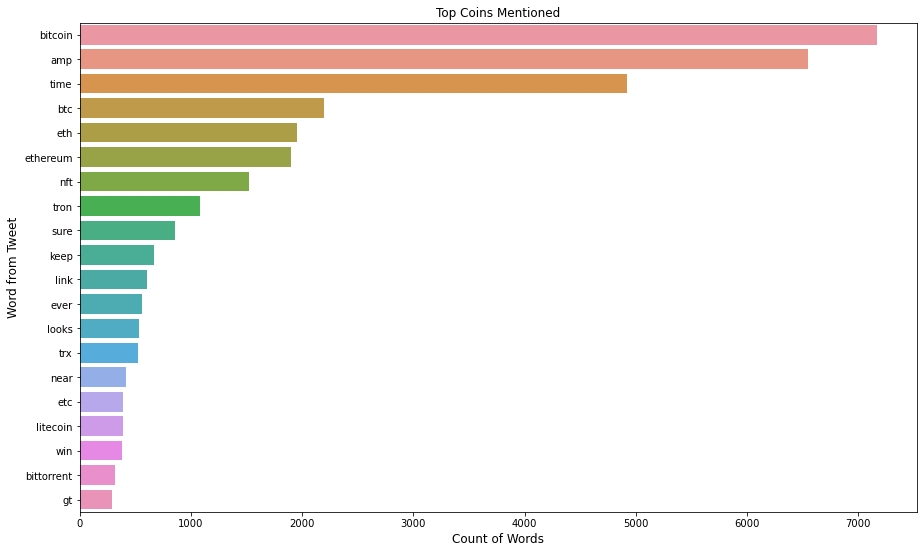

In [36]:
# chart of top words mentioned. Something to note, many of these words are commonly used words that are also either coin names or tickers. 
coins_in_tweet = coins_in_tweet[:20]
plt.figure(figsize=(15,9))
sns.barplot(x='count', y='word',data=coins_in_tweet)
plt.title('Top Coins Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [37]:
# export to csv
# coins_in_tweet.to_csv('coins_in_tweet.csv')